In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools as fc
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')




In [2]:
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
products_dataset = pd.read_csv('olist_products_dataset.csv')
sellers_dataset = pd.read_csv('olist_sellers_dataset.csv')
category_name = pd.read_csv('product_category_name_translation.csv')

raw_datasets = [customers,geolocation,order_items,order_payments,order_reviews,orders_dataset,sellers_dataset,category_name,products_dataset]
order_id_link = [order_payments,order_reviews,orders_dataset,order_items]

In [3]:
df_1 = pd.merge(customers,orders_dataset,how='outer',on='customer_id')


df_2 = pd.merge(df_1,order_reviews,how='outer',on='order_id')

df_3 = pd.merge(df_2,order_payments,how='outer',on='order_id')

raw = pd.merge(df_3,order_items,how='outer',on='order_id')

In [4]:
def create_dataset(raw,date):
    raw['order_purchase_timestamp']= pd.to_datetime(raw['order_purchase_timestamp'])
    df = raw[raw['order_purchase_timestamp']<date]
    df = df[df['order_status']=='delivered']
    df = df.groupby(['customer_unique_id','order_id']).agg({
    'price' : 'sum',
    'review_score' : 'mean',
    'order_purchase_timestamp' : 'min'
}).reset_index()
    df = pd.pivot_table(df,
                        values=df.drop(columns='customer_unique_id').columns,
                        index=['customer_unique_id'],
                        aggfunc={
                            'order_id': len,
                            'price' : [sum,np.mean],
                            'review_score' : np.mean,
                            'order_purchase_timestamp' : max
                        }).reset_index()
    df.columns = df.columns.droplevel(0)
    df.columns=['customer_unique_id','order_count','last_order','mean_payment_item','total_payment_item','mean_review']
    df['days_since_last_order'] = ((max(df['last_order']) - df['last_order']) / pd.Timedelta(1, unit='d')).round()
    df = df[df['total_payment_item']<5000]
    df = df.dropna(how='any')
    return df


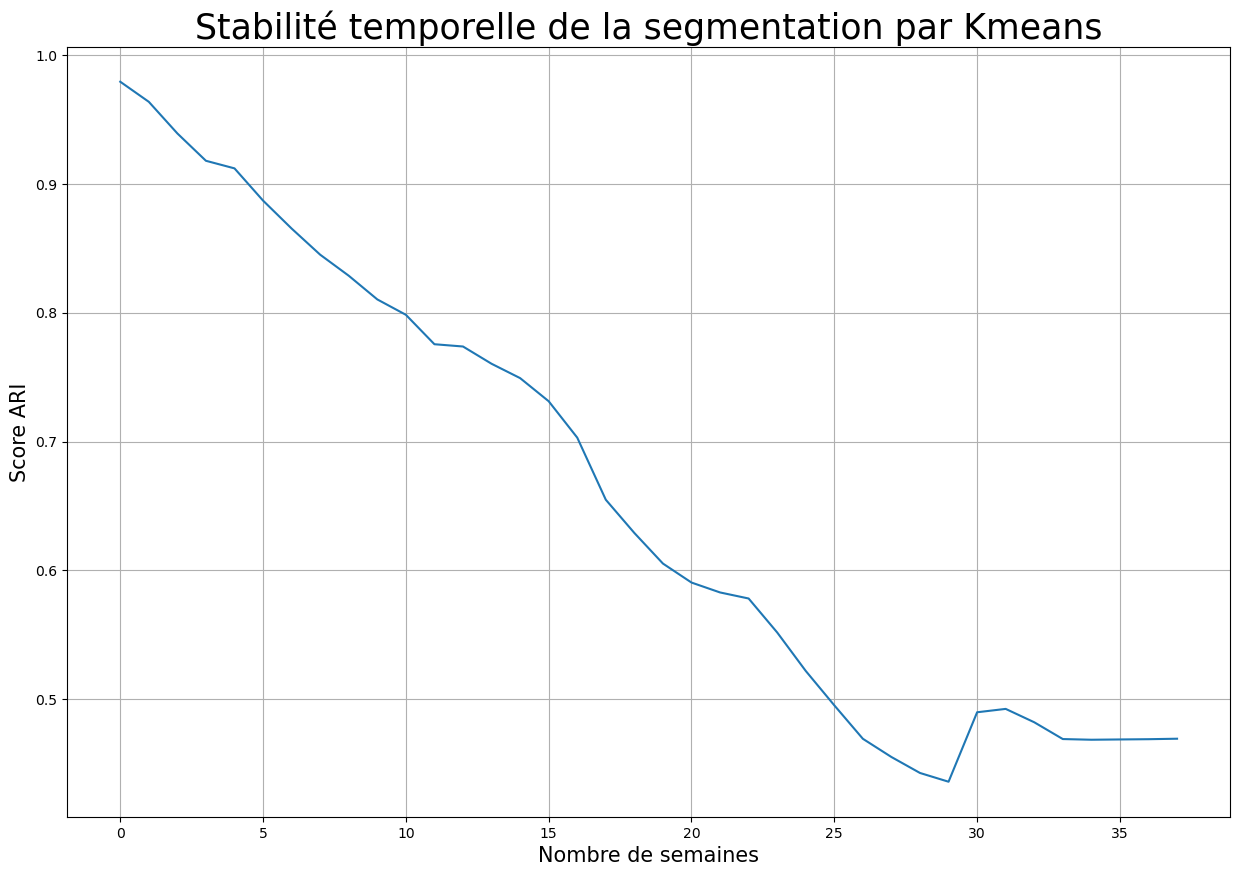

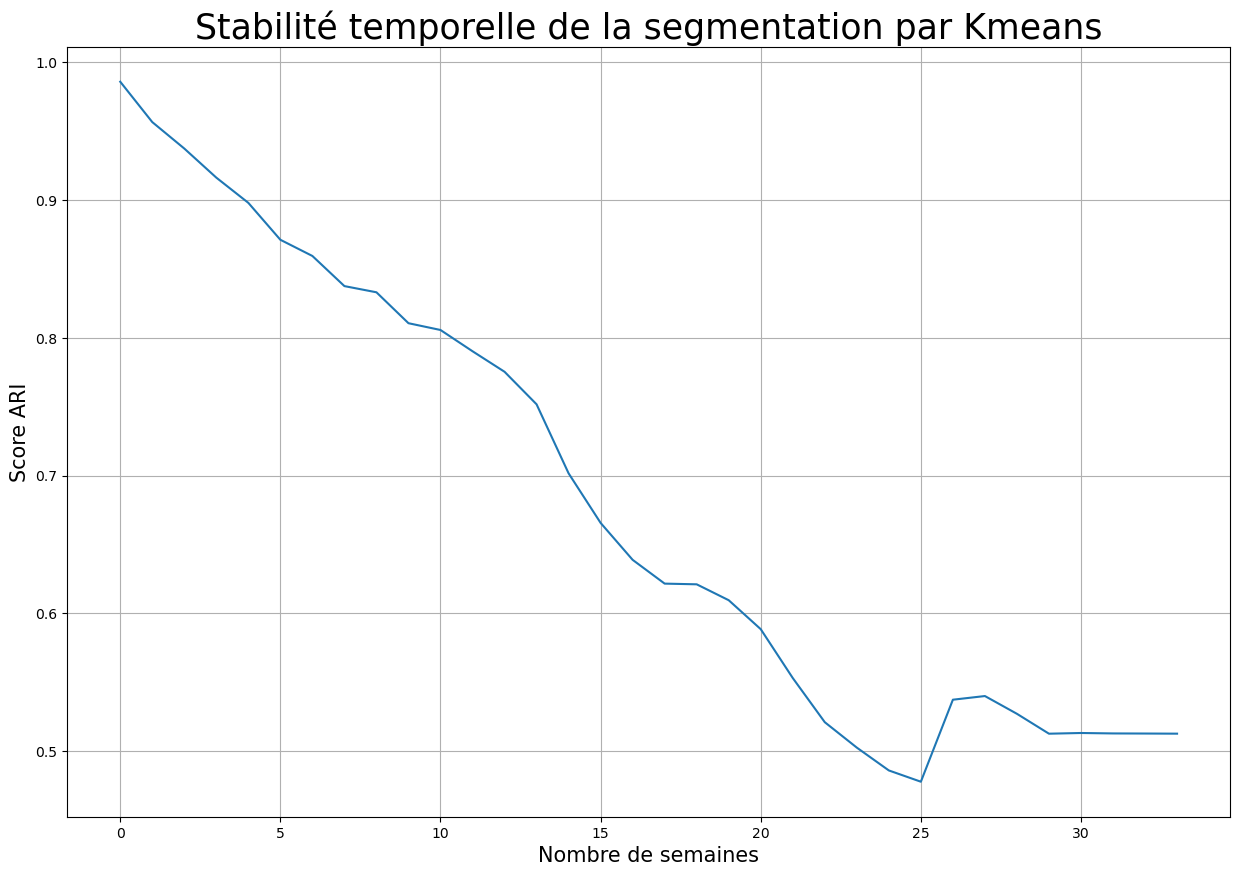

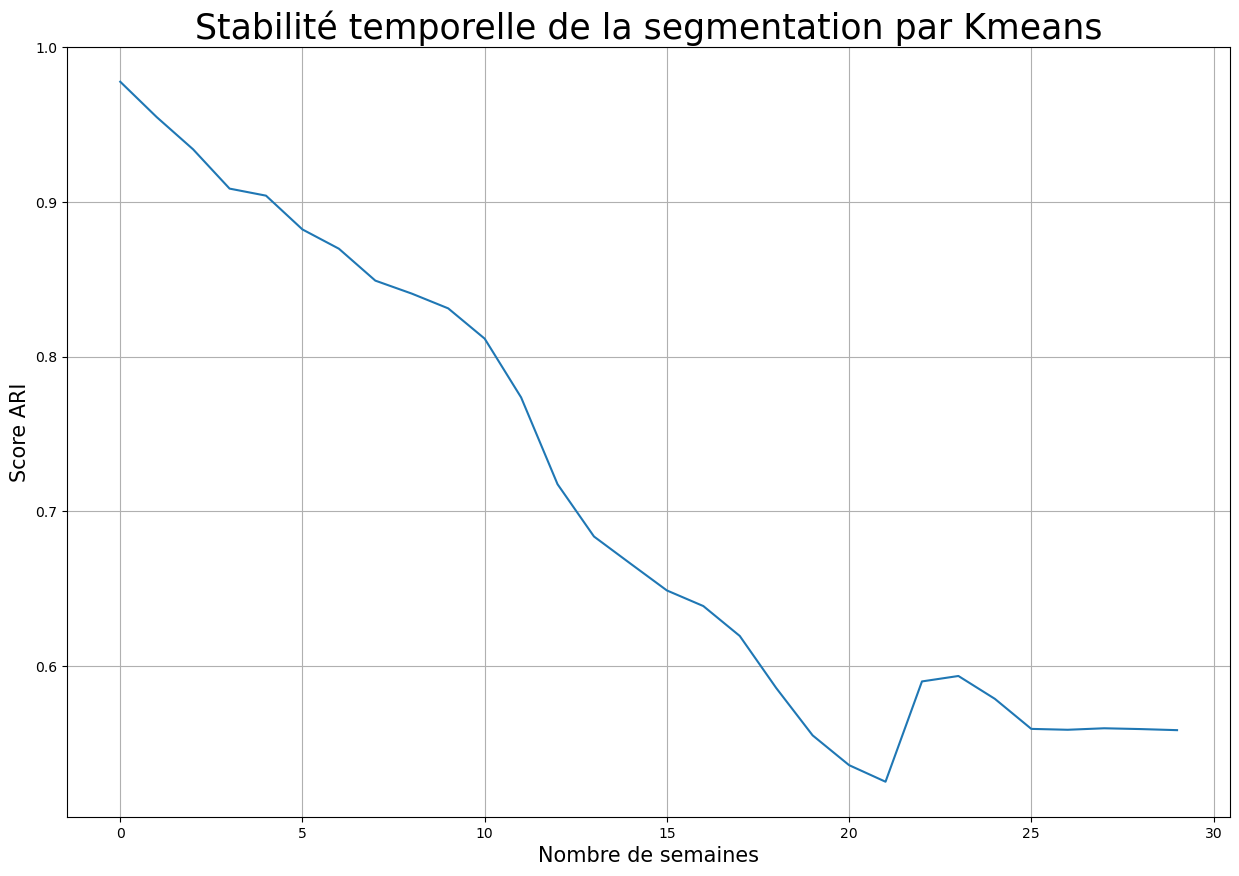

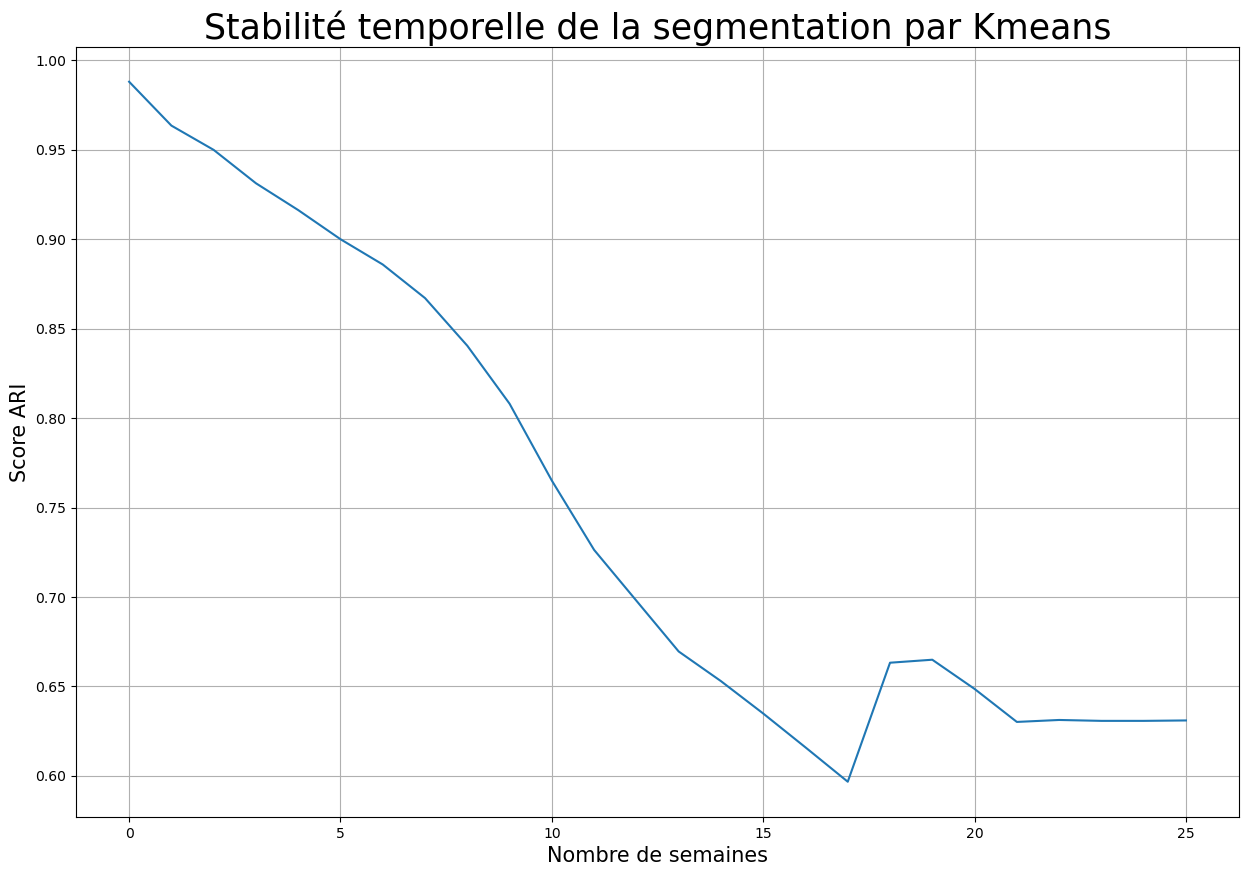

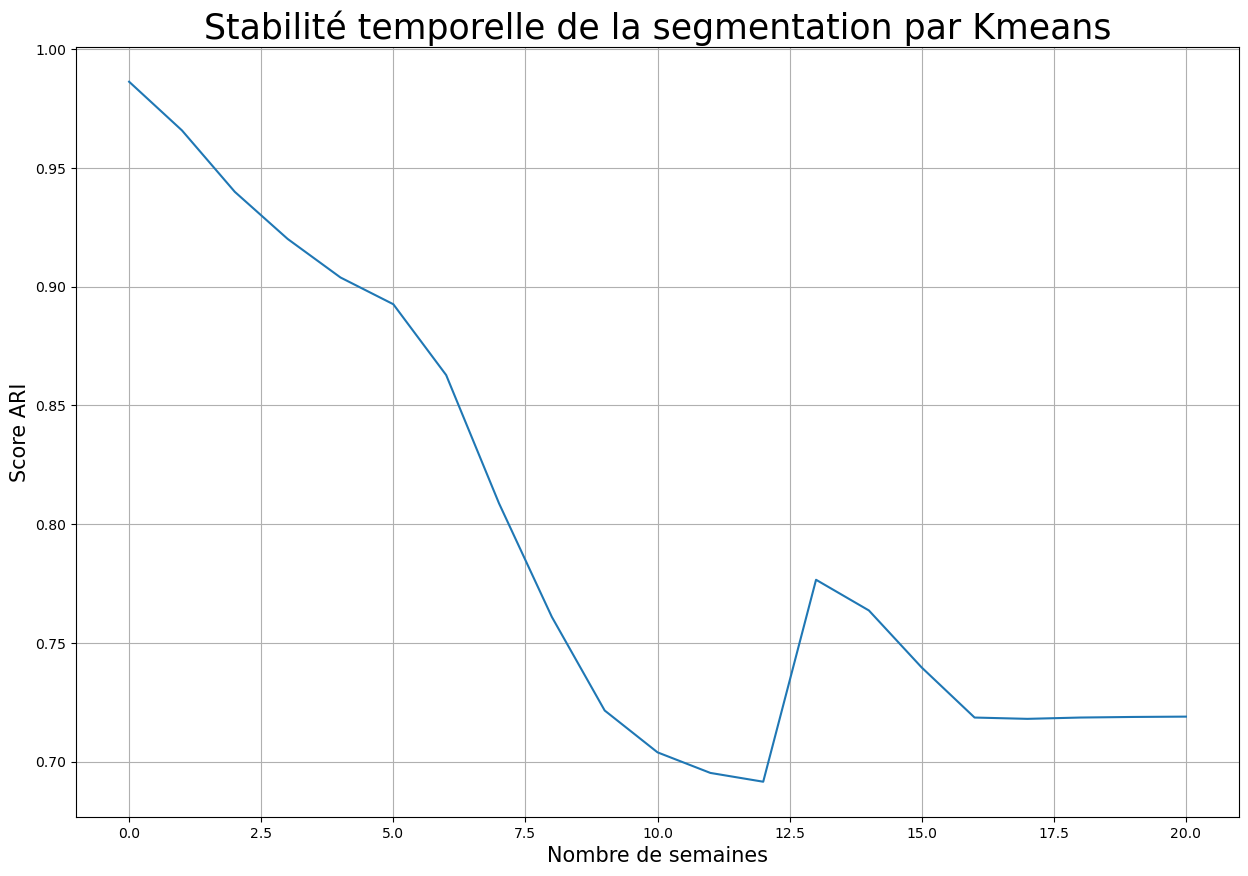

In [10]:
for i in ['2018-01-01','2018-02-01','2018-03-01','2018-04-01','2018-05-01']:
    
    dates = pd.date_range(start=i, end='2018-10-01', freq='W')
    scaler = StandardScaler()
    df= create_dataset(raw,dates[0])
    X= scaler.fit_transform(df[['order_count','mean_payment_item','mean_review','days_since_last_order']])
    old_model = KMeans(n_clusters=5, n_init=10).fit(X)
    ARI_list = list()
    for date in dates[1:] :
        df= create_dataset(raw,date)
        X= scaler.transform(df[['order_count','mean_payment_item','mean_review','days_since_last_order']])
        X_new = StandardScaler().fit_transform(X)
        new_model = KMeans(n_clusters=5, n_init=10).fit(X_new)
        old_clusters = old_model.predict(X)
        new_clusters = new_model.predict(X_new)
        ari = adjusted_rand_score(new_clusters,old_clusters)
        ARI_list.append(ari)
        
    plt.figure(figsize=[15,10])
    plt.title("Stabilité temporelle de la segmentation par Kmeans",fontsize=25)
    plt.xlabel('Nombre de semaines',fontsize=15)
    plt.ylabel('Score ARI',fontsize=15)
    plt.plot(ARI_list)
    plt.grid(visible = True, axis = 'both')